In [1]:
import numpy as np
import pandas as pd
from utils import get_data, get_preds, get_table, plot_rsme, other_stats, add_intervals_to_test, plot_interval_check, plot_interval_sizes
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=1000, train_tup=(2021, 2023))
train.to_csv("processed_data/train.csv")
test.to_csv("processed_data/test.csv")
# test = pd.read_csv("processed_data/test.csv")

In [2]:
model_info = [
    ("no_curr_pace", "stan_results/params1.csv", ['total_pace', 'prop'], ['beta.1', 'beta.2'], True),
    ("with_curr_pace", "stan_results/params2.csv", ['total_pace', 'curr_pace', 'prop'], ['beta.1', 'beta.2', 'beta.3'], True),
    ("rstan2d", "stan_results/rs_result2d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),
]
models = {name: pd.read_csv(path) for (name, path, feats, betas, pleft) in model_info}
mpreds = {name: get_preds(test, pd.read_csv(path), feats_lis=feats, beta_lis=betas, propleft=pleft, name=name)
           for (name, path, feats, betas, pleft) in model_info}

test2 = get_table(test, mpreds)
test2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,male,propxcurr,malexage,extrap,no_curr_pace,with_curr_pace,rstan2d
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,1,0.610812,31,-3.702833,3.303172,3.342777,3.345261
29,286806,5K,5.681818,5.681818,5.011283,38,M,2023,0.118497,0.881503,1,0.673281,38,-16.561333,-10.791484,-10.724699,-10.722722
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,0,0.554244,0,5.388183,13.899908,13.901554,13.904668
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,1,0.580301,30,-2.696350,5.066098,5.087218,5.090017
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,1,0.606435,41,-11.551617,-4.444194,-4.406993,-4.404467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,0,1.546459,0,-0.910996,0.510056,1.921738,1.919472
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,0,1.638402,0,-2.888940,-1.474314,-1.480089,-1.481255
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.052020,1,1.605113,60,-2.965773,-1.543473,-1.123718,-1.125218
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.052020,1,1.356971,64,-4.780504,-3.366740,1.308243,1.303431


In [3]:
# s_data =pd.DataFrame([[4, 0.2, .5], [3, 0.5, .75]], columns=["total_pace", "prop", "propleft"])
# get_preds(s_data, models['rstan2c'], feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"], full=True)

,no_curr_pace,with_curr_pace,extrap,no_curr_pace_,with_curr_pace_
dist,,,,,
5K,17.186473,17.015182,17.949925,0.042532,0.052075
10K,13.516352,13.225022,17.030332,0.206337,0.223443
15K,11.269320,10.974633,15.659996,0.280375,0.299193
20K,9.260069,8.920168,13.330850,0.305365,0.330863
25K,7.618082,7.242117,11.200824,0.319864,0.353430
30K,5.754797,5.243184,7.903727,0.271888,0.336619
35K,3.783593,3.278807,4.350297,0.130268,0.246303
40K,1.134416,0.994469,1.172183,0.032219,0.151610


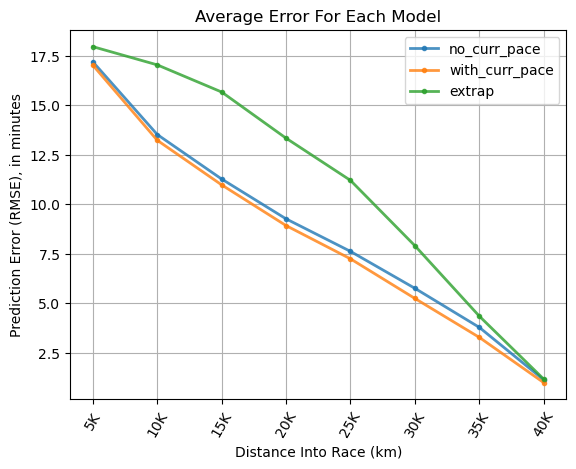

In [4]:
labels = ["no_curr_pace", "with_curr_pace", "extrap"]
rmse_table = plot_rsme(test2, labels, "all_errors")
rmse_table["no_curr_pace_"] = 1 - (rmse_table["no_curr_pace"] / rmse_table["extrap"])
rmse_table["with_curr_pace_"] = 1 - (rmse_table["with_curr_pace"] / rmse_table["extrap"])
rmse_table

In [5]:
other_stats(test2[labels], test2["finish"])

,no_curr_pace,with_curr_pace,extrap
0,9.984791,9.721808,12.466984
1,0.947370,0.950106,0.917950


In [6]:
mpreds2 = {name: (42195 / 60) / get_preds(test, pd.read_csv(path), feats_lis=feats, beta_lis=betas, propleft=pleft, name=name, full=True)
           for (name, path, feats, betas, pleft) in model_info}
# model_preds2["new1"] = (42195 / 60) / get_preds(test, pd.read_csv("stan_results/params1.csv"), feats_lis=['total_pace', 'curr_pace', 'prop'], beta_lis=['beta.1', 'beta.2', 'beta.3'], propleft=True, full=True)

<Figure size 4000x4000 with 0 Axes>

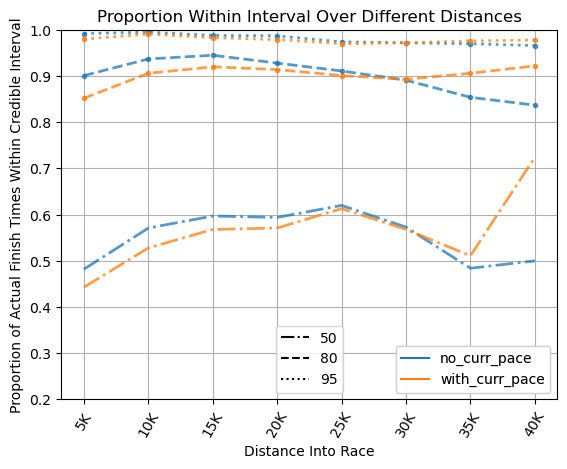

<Figure size 3000x2000 with 0 Axes>

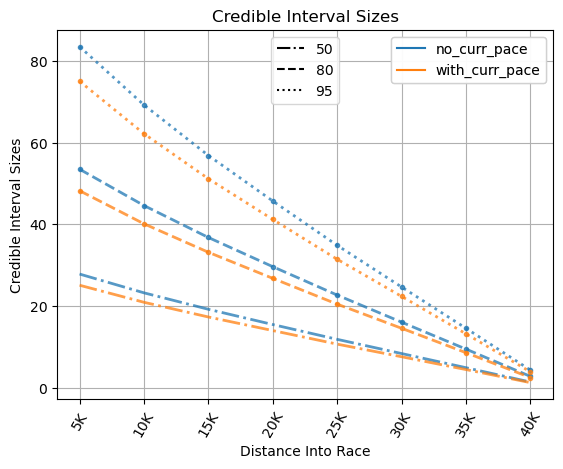

In [7]:
pred_names = labels[:2]
intervals_tbl = add_intervals_to_test(test2, mpreds2, pred_names)
i_check = plot_interval_check(intervals_tbl, pred_names)
i_sizes = plot_interval_sizes(intervals_tbl, pred_names)